<a href="https://colab.research.google.com/github/thiagomelostuckert/datathon-fakenews/blob/main/1_An%C3%A1lise_Gr%C3%A1fica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise gráfica da base de dados e preparação para construção de modelo de detecção utilizando técnicas de aprendizado de máquina

A equipe recebeu em anexo os arquivos ‘train_data.csv’ e ‘train_labels.csv’. O arquivo ‘train_data.csv’ contém 6480 notícias verdadeiras ou falsas, sendo o respectivo rótulo indicado no arquivo ‘train_labels.csv’. Já foi feito um primeiro preprocessamento nos textos das notícias (que não impede novas etapas de preprocessamento se assim a equipe julgar necessário).
A base de dados original utilizada está disponível no github (https://github.com/roneysco/Fake.br-Corpus/tree/master) e foi utilizada na tese de doutorado do Dr. Roney Lira de Sale Santos. A escolha da base de dados foi determinada por critérios estritamente didáticos, e a rotulação dos dados não foi validada pela ABIN.
Competirá principalmente ao analista de dados a análise exploratória gráfica da base de dados para gerar as primeiras impressões e informações sobre cada tipo de notícia. Sugere-se as bibliotecas padrão do Python para esta finalidade, como Matplotlib, seaborn, pandas e plotly.
Além disso, o analista de dados deverá preparar a base de dados para ser utilizada pelo cientista de dados, o que envolve preparação específica a partir do modelo escolhido por este último.
A avaliação dessa etapa se dará a partir da pertinência, completude e eficiência de código das visualizações geradas da base de dados.


Importação das bibliotecas

In [71]:
import pandas as pd

# Pré-processamento
import nltk
from nltk.stem import RSLPStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Criação da nuvem de palavras
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import numpy as np
from os import path
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Conversão do texto em uma matriz TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Utilizados na hora de salvar o arquivo com a matriz TF-IDF
import gzip
import pickle

#Biblioteca utilizada no pré-processamento de textos (lematização)
import spacy
from spacy.lang.pt.examples import sentences

from spacy.tokenizer import Tokenizer
from spacy.lang.pt import Portuguese
import re
from collections import Counter

!pip install Unidecode
from unidecode import unidecode

!pip install yake
import yake

#Baixa o corpus utilizado na próxima análise
# Referência: https://spacy.io/models/pt#pt_core_news_md
# Observação:tem a opção de carregar datasets maiores
!spacy download pt_core_news_md

#Bibliotecas abaixo tiveram problema de instalação
#!pip install cyhunspell
#from hunspell import Hunspell

#!pip install contextualSpellCheck
#import contextualSpellCheck


#Biblioteca usada para obter links nos textos
# É necessário fazer um downgrade da biblioteca spacy para funcionar o a biblioteca neuralcoref
#!pip install spacy==2.1.0
#!pip install neuralcoref
#import neuralcoref

# Também seria necessário alterar a versão do python para 3.7 que a biblioteca neuralcoref funcione
#!sudo apt-get install python3.7
#!sudo apt-get update -y
#!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
#!sudo update-alternatives --config python3 <<< '2'
#!python --version

2023-11-30 01:25:41.914897: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 01:25:41.915003: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 01:25:41.915049: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 01:25:43.415996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 13.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')


### Leitura do arquivo pré-processado

In [8]:
#Leitura dos textos
url_train_data = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_data.csv"
df_train_data = pd.read_csv(url_train_data, on_bad_lines = 'warn')

In [9]:
#Leitura das labels
url_train_label = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_labels.csv"
df_train_label = pd.read_csv(url_train_label, on_bad_lines = 'warn')

### Análises dos *dados*

In [10]:
#Apresenta as colunas do dataframe
print(df_train_data.columns)
print(df_train_label.columns)

Index(['preprocessed_news'], dtype='object')
Index(['label'], dtype='object')


In [11]:
#Junta os dois datasets em um único dataframe
df = pd.merge(df_train_data, df_train_label, left_index=True, right_index=True)
df.columns

Index(['preprocessed_news', 'label'], dtype='object')

In [12]:
#Mostra a quantidade de notícias falsas e verdadeiras
df['label'].value_counts()

fake    3240
true    3240
Name: label, dtype: int64

<Axes: >

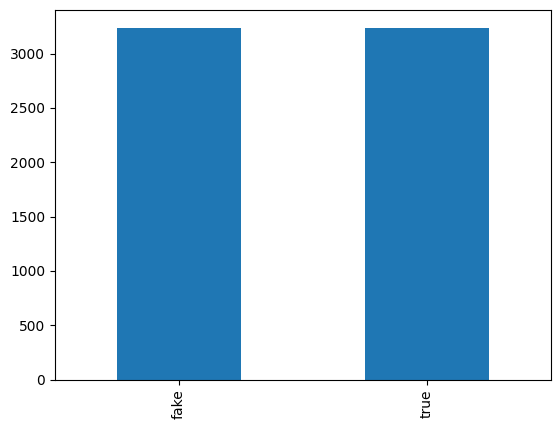

In [13]:
# Apresenta gráfico com a quantidade de notícias falsas e verdadeiras
# Observamos que o dataset está balanceado
df['label'].value_counts().plot.bar()

In [14]:
#Mostra as primeiras linhas do dataframe
df.head()

,preprocessed_news,label
0,suica encontra contas ilicitas usadas abastece...,fake
1,genro silvio santos lista lava jato silvio san...,fake
2,linha credito imobiliario tera orcamento menor...,true
3,cerimonia oscar ultimo domingo mulheres roubar...,true
4,pais usa calor internet aquecer casas projeto ...,true


Contagem da frequência das palavras

In [15]:
df_true = df[df.label == "true"]

In [16]:
#Quantidade de palavras analisadas com mais frequência ou menos frequência
qtde_palavras=50

In [17]:
df_true_word_count = df_true.preprocessed_news.str.split(expand=True).stack().value_counts().sort_values(ascending=False).rename_axis('Palavras').reset_index(name='Frequência')

df_true_word_count_first = df_true_word_count[:qtde_palavras]
df_true_word_count_first

,Palavras,Frequência
0,nao,32379
1,sao,8720
2,ser,8716
3,tambem,8610
4,presidente,7849
5,lula,7826
6,sobre,7488
7,disse,7351
8,anos,7347
9,federal,6802


<Figure size 1500x1000 with 0 Axes>

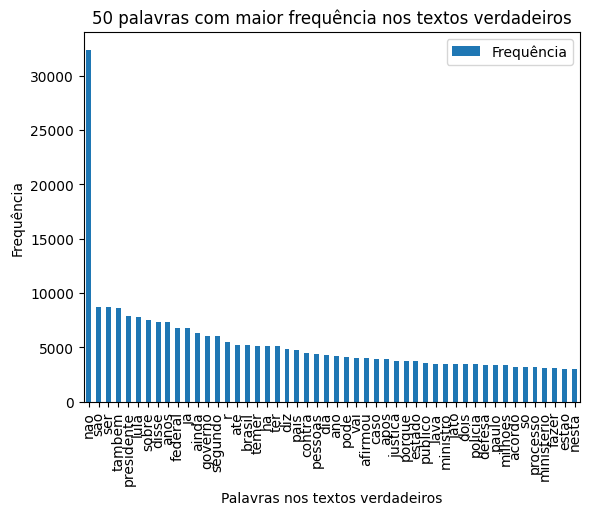

In [18]:
plt.figure(figsize=(15,10))
df_true_word_count_first.plot.bar(x='Palavras', y='Frequência')
plt.title(f"{qtde_palavras} palavras com maior frequência nos textos verdadeiros")
plt.xticks(rotation=90)
plt.xlabel("Palavras nos textos verdadeiros")
plt.ylabel("Frequência")
plt.show()

In [19]:
df_true_word_count_least = df_true_word_count.tail(qtde_palavras)
df_true_word_count_least

,Palavras,Frequência
71259,nelito,1
71260,influenciavel,1
71261,mesulam,1
71262,desafiadores,1
71263,monitoravam,1
71264,exaustos,1
71265,pencas,1
71266,cerra,1
71267,assassinam,1
71268,insuspeita,1


<Figure size 1500x1000 with 0 Axes>

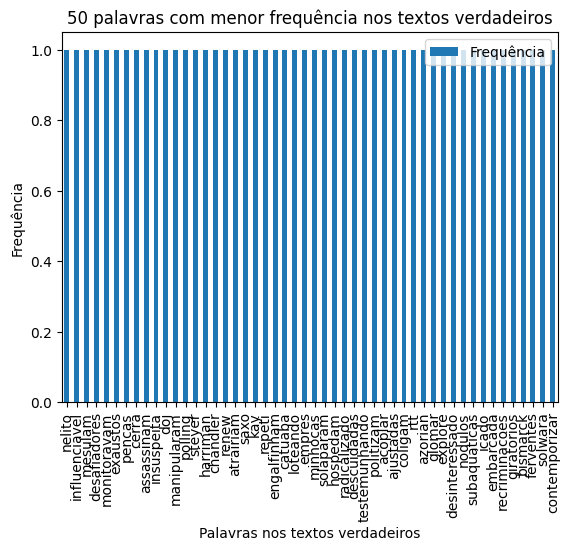

In [20]:
plt.figure(figsize=(15,10))
df_true_word_count_least.plot.bar(x='Palavras', y='Frequência')
plt.title(f"{qtde_palavras} palavras com menor frequência nos textos verdadeiros")
plt.xticks(rotation=90)
plt.xlabel("Palavras nos textos verdadeiros")
plt.ylabel("Frequência")
plt.show()

In [21]:
# Reparei que muitas palavras tem apenas uma ocorrência
word_freq_1_true = df_true_word_count[df_true_word_count.Frequência == 1]["Frequência"].count()
word_freq_1_true

26057

In [22]:
# Total das palavras
word_freq_total_true = df_true_word_count["Frequência"].count()
word_freq_total_true

71309

In [23]:
percentual_word_freq_1 = (word_freq_1_true/word_freq_total_true)*100
print("{:.2f}% das palavras tem apenas uma única ocorrência nos textos verdadeiros".format(percentual_word_freq_1))

36.54% das palavras tem apenas uma única ocorrência nos textos verdadeiros


In [24]:
df_fake = df[df.label == "fake"]

In [25]:
df_fake_word_count = df_fake.preprocessed_news.str.split(expand=True).stack().value_counts().sort_values(ascending=False).rename_axis('Palavras').reset_index(name='Frequência')
df_fake_word_count_first = df_fake_word_count[:qtde_palavras]
df_fake_word_count_first

,Palavras,Frequência
0,nao,5648
1,lula,2766
2,disse,1974
3,dilma,1664
4,presidente,1656
5,ser,1483
6,tambem,1443
7,ja,1314
8,sao,1291
9,brasil,1284


<Figure size 1500x1000 with 0 Axes>

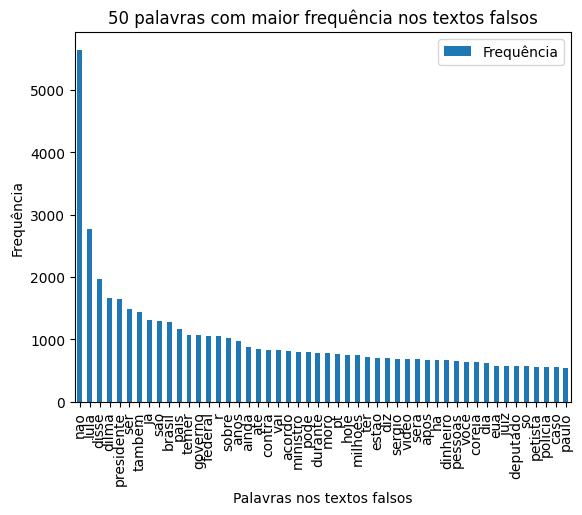

In [26]:
plt.figure(figsize=(15,10))
df_fake_word_count_first.plot.bar(x='Palavras', y='Frequência')
plt.title(f"{qtde_palavras} palavras com maior frequência nos textos falsos")
plt.xticks(rotation=90)
plt.xlabel("Palavras nos textos falsos")
plt.ylabel("Frequência")
plt.show()

In [27]:
df_fake_word_count_least = df_fake_word_count.tail(qtde_palavras)
df_fake_word_count_least

,Palavras,Frequência
30336,absorvido,1
30337,entrincheirada,1
30338,estimulasse,1
30339,estimulava,1
30340,visse,1
30341,troia,1
30342,canudos,1
30343,bassi,1
30344,listras,1
30345,constavam,1


<Figure size 1500x1000 with 0 Axes>

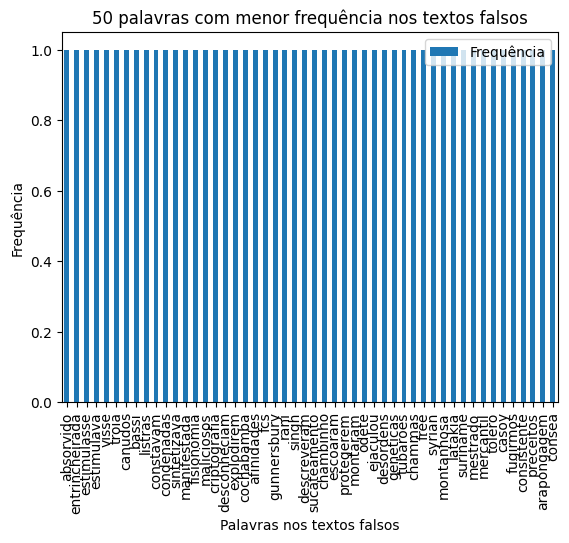

In [28]:
plt.figure(figsize=(15,10))
df_fake_word_count_least.plot.bar(x='Palavras', y='Frequência')
plt.title(f"{qtde_palavras} palavras com menor frequência nos textos falsos")
plt.xticks(rotation=90)
plt.xlabel("Palavras nos textos falsos")
plt.ylabel("Frequência")
plt.show()

In [29]:
# Reparei que muitas palavras tem apenas uma ocorrência
word_freq_1_fake = df_fake_word_count[df_fake_word_count.Frequência == 1]["Frequência"].count()
word_freq_1_fake

12171

In [30]:
word_freq_total_fake = df_fake_word_count["Frequência"].count()
word_freq_total_fake

30386

In [31]:
percentual_word_freq_1 = (word_freq_1_fake/word_freq_total_fake)*100
print("{:.2f}% das palavras tem apenas uma única ocorrência nos textso falsos".format(percentual_word_freq_1))

40.05% das palavras tem apenas uma única ocorrência nos textso falsos


In [32]:
# Percentual de frequência para palavras com N ocorrências
def percentual_word_freq(df_word_count, n):
  word_freq = df_word_count[df_word_count.Frequência == n]["Frequência"].count()
  word_freq_total = df_word_count["Frequência"].count()
  percentual_word_freq = (word_freq/word_freq_total)*100
  return percentual_word_freq

In [33]:
print("Percentual de palavras com N ocorrências para textos verdadeiros e fakes")
print("Núm. de ocorrências \t Verdadeiros (%) \t Fakes (%)")
for n in range(1,10):
  print(f"{n}\t\t\t {percentual_word_freq(df_true_word_count,n):.2f}\t\t\t {percentual_word_freq(df_fake_word_count,n):.2f}")


Percentual de palavras com N ocorrências para textos verdadeiros e fakes
Núm. de ocorrências 	 Verdadeiros (%) 	 Fakes (%)
1			 36.54			 40.05
2			 13.98			 15.48
3			 8.13			 8.62
4			 5.24			 5.70
5			 3.83			 3.83
6			 2.87			 3.12
7			 2.34			 2.34
8			 1.93			 1.88
9			 1.60			 1.52


In [34]:
print(f"Reparamos que a variedade de palavras diferentes nos textos verdadeiros ({word_freq_total_true}) é maior do que nos textos falsos ({word_freq_total_fake}). ")
print("É um indicativo que os textos falsos tem um vocabulário mais limitado.")


Reparamos que a variedade de palavras diferentes nos textos verdadeiros (71309) é maior do que nos textos falsos (30386). 
É um indicativo que os textos falsos tem um vocabulário mais limitado.


In [35]:
# Cruzamento das palavras mais frequentes nos textos falsos e verdadeiros
df_all_word_count_first = pd.merge(df_fake_word_count_first,df_true_word_count_first, how ='outer', on =['Palavras', 'Palavras'], suffixes=('_fake','_true'), indicator=True)
df_all_word_count_first.head(2*qtde_palavras)


,Palavras,Frequência_fake,Frequência_true,_merge
0,nao,5648.0,32379.0,both
1,lula,2766.0,7826.0,both
2,disse,1974.0,7351.0,both
3,dilma,1664.0,NaN,left_only
4,presidente,1656.0,7849.0,both
...,...,...,...,...
60,defesa,NaN,3382.0,right_only
61,processo,NaN,3185.0,right_only
62,ministerio,NaN,3095.0,right_only
63,fazer,NaN,3083.0,right_only


In [36]:
# As palavras que aparecem com mais frequência tanto nos textos falsos quanto verdadeiros
df_fake_and_true_first = df_all_word_count_first[df_all_word_count_first['_merge'] == 'both']
df_fake_and_true_first.head(qtde_palavras)

,Palavras,Frequência_fake,Frequência_true,_merge
0,nao,5648.0,32379.0,both
1,lula,2766.0,7826.0,both
2,disse,1974.0,7351.0,both
4,presidente,1656.0,7849.0,both
5,ser,1483.0,8716.0,both
6,tambem,1443.0,8610.0,both
7,ja,1314.0,6769.0,both
8,sao,1291.0,8720.0,both
9,brasil,1284.0,5219.0,both
10,pais,1170.0,4715.0,both


In [37]:
# As palavras que aparecem com mais frequência apenas nos textos falsos
df_fake_only_first = df_all_word_count_first[df_all_word_count_first['_merge'] == 'left_only']
df_fake_only_first.head(qtde_palavras)

,Palavras,Frequência_fake,Frequência_true,_merge
3,dilma,1664.0,NaN,left_only
24,durante,788.0,NaN,left_only
25,moro,784.0,NaN,left_only
26,pt,768.0,NaN,left_only
27,hoje,753.0,NaN,left_only
32,sergio,679.0,NaN,left_only
33,video,678.0,NaN,left_only
34,sera,678.0,NaN,left_only
37,dinheiro,670.0,NaN,left_only
39,voce,640.0,NaN,left_only


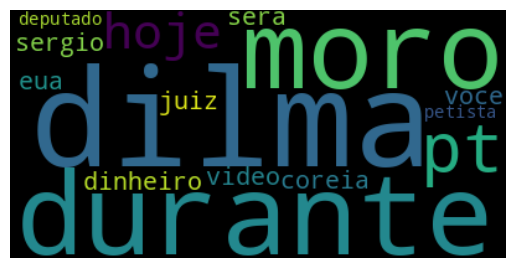

In [38]:
# Nuvem de palavras que aparecem com mais frequência nos textos falsos
text = " ".join(news for news in df_fake_only_first.Palavras)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [39]:
# As palavras que aparecem com mais frequência apenas nos textos verdadeiros
df_true_only_first = df_all_word_count_first[df_all_word_count_first['_merge'] == 'right_only']
df_true_only_first.head(qtde_palavras)

,Palavras,Frequência_fake,Frequência_true,_merge
50,segundo,NaN,6052.0,right_only
51,ano,NaN,4234.0,right_only
52,afirmou,NaN,4019.0,right_only
53,justica,NaN,3743.0,right_only
54,porque,NaN,3712.0,right_only
55,estado,NaN,3706.0,right_only
56,publico,NaN,3557.0,right_only
57,lava,NaN,3484.0,right_only
58,jato,NaN,3477.0,right_only
59,dois,NaN,3433.0,right_only


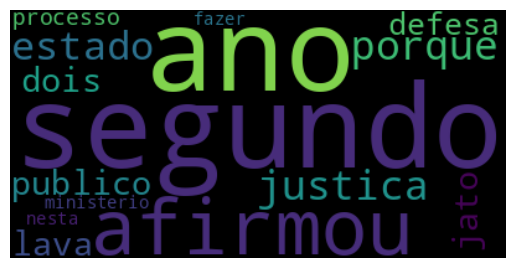

In [40]:
# Nuvem de palavras que aparecem com mais frequência nos textos verdadeiros
text = " ".join(news for news in df_true_only_first.Palavras)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Tratamento dos dados para servir como entrada dos modelos de aprendizado de máquina
Na próxima etapa da construção do modelo de aprendizado de máquina será necessário transformar os textos em uma matriz de frequências invertidas das palavras, conhecida em inglês por term Frequency - Inverse Document Frequency (TF-IDF). Para isso podemos utilizar a biblioteca sklearn TfidfVectorizer

Referências:
https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://www.educative.io/answers/how-to-use-tf-idf-vectorizer-on-dataframe

In [41]:
df.shape

(6480, 2)

In [42]:
#Cria o vectorizer que será preenchido com as frequências
vectorizer = TfidfVectorizer()
#Popula com as frequências dos textos
X = vectorizer.fit_transform(df.preprocessed_news)
print(X.toarray())
print(X.shape)

with gzip.open('matrix-tf-idf.pkl', 'wb') as f:
    pickle.dump(X, f)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(6480, 76289)


In [43]:
# Vocabulário dos textos
tfidf_tokens = vectorizer.get_feature_names_out()
tfidf_tokens

array(['aa', 'aabb', 'aabertura', ..., 'zwi', 'zygmun', 'zygmunt'],
      dtype=object)

### Hipótese textos falsos possuem vocabulário mais pobre

In [44]:
fake_texts = df_fake.preprocessed_news.to_list()
fake_words = []
for text in fake_texts:
  fake_words+=text.split()
print(f"As três primeiras palavras em textos falsos: {fake_words[:3]}")
print(f"A quantidade total de palavras em textos falsos: {len(fake_words)}")
#Remove as palavras duplicadas
unique_fake_words = list(set(fake_words))
print(f"Quantidade de palavras sem duplicidade em textos falsos: {len(unique_fake_words)}")
mean_fake_words = np.mean([len(s) for s in unique_fake_words])
print(f"Tamanho médio de palavras em textos falsos: {mean_fake_words:.2f}")

As três primeiras palavras em textos falsos: ['suica', 'encontra', 'contas']
A quantidade total de palavras em textos falsos: 351515
Quantidade de palavras sem duplicidade em textos falsos: 30386
Tamanho médio de palavras em textos falsos: 8.04


In [45]:
true_texts = df_true.preprocessed_news.to_list()
true_words = []
for text in true_texts:
  true_words+=text.split()
print(f"As três primeiras palavras em textos verdadeiros: {true_words[:3]}")
print(f"A quantidade total de palavras em textos verdadeiros: {len(true_words)}")
#Remove as palavras duplicadas
unique_true_words = list(set(true_words))
print(f"Quantidade de palavras sem duplicidade em textos verdadeiros: {len(unique_true_words)}")
mean_true_words = np.mean([len(s) for s in unique_true_words])
print(f"Tamanho médio de palavras em textos verdadeiros: {mean_true_words:.2f}")

As três primeiras palavras em textos verdadeiros: ['linha', 'credito', 'imobiliario']
A quantidade total de palavras em textos verdadeiros: 2019744
Quantidade de palavras sem duplicidade em textos verdadeiros: 71309
Tamanho médio de palavras em textos verdadeiros: 8.29


In [46]:
#Calcula o tamanho de cada texto
df["Tamanho do texto"] = df["preprocessed_news"].str.len()
df.head(20)

,preprocessed_news,label,Tamanho do texto
0,suica encontra contas ilicitas usadas abastece...,fake,843
1,genro silvio santos lista lava jato silvio san...,fake,941
2,linha credito imobiliario tera orcamento menor...,true,2528
3,cerimonia oscar ultimo domingo mulheres roubar...,true,2586
4,pais usa calor internet aquecer casas projeto ...,true,7238
5,operacao lava jato denunciou nesta jose dirceu...,true,8876
6,pgr recebe documento pedindo interdicao dilma ...,fake,799
7,violencia faz brasil viver processo desciviliz...,true,9995
8,eleicoes criar propagar boatos crime justica e...,true,9920
9,tv record mostra ascensao familia silva filho ...,fake,395


In [47]:
# Calcula o tamanho médio dos textos para cada tipo de label, mostrando que os textos falsos são mais curtos
df_mean_len_text = df.groupby("label", as_index=False)['Tamanho do texto'].mean()
df_mean_len_text

,label,Tamanho do texto
0,fake,820.244136
1,true,4824.557099


In [48]:
# Um jeito mais complicado de fazer a mesma operação
df_words_true = df_true.preprocessed_news.str.split(expand=True).stack().reset_index()[0].tolist()
print(f"A quantidade de palavras em textos verdadeiros obtidas por esse outro método: {len(df_words_true)}")


A quantidade de palavras em textos verdadeiros obtidas por esse outro método: 2019744


## Pistas linguísticas

In [49]:
text="sinal tres poderes republica nao temem possibilidade punicao boca urna dado dias deste mes congresso nacional criou fundo financiamento campanha fazendo unica concessao trocar insultada democracia descricao factual objetivo dinheiro farto melhor piso teto bancar certamente bilionarias campanhas eleitorais dinheiro tungado contribuinte mesma ocasiao turma reunida abrigo cumbuca virada tigela emborcada concedeu membros merce pegar dinheiro emprestado cofres viuva comprometer pagar nao quer dizer pagarao dividas uniao conjunto espoliado povo brasileiro logo seguida votacao decidida voto coluna meio presidente belas frases vazias supremo tribunal federal stf carmen lucia judiciario devolveu nada insignes tambem nada insignificantes parlamentares poder tornarem foro superprivilegio intocaveis antes disso executivo alto poder monarquico havia recorrido expedientes rotina garantir imunidade pe meio chefe concluido processo esvaziamento cofres todos receptaculos suado amarfanhado dinheiro escorchado contribuintes parte sobrou saque promovido dois aliados antanho luiz inacio lula silva dilma janete vana rousseff linhares comprar discricao zero apoio terco deputados federais permaneca poder nao trata claro algo inusitado sequer original pratica vem tempos idos certamente sera repetida dias ainda nao vividos governos todas origens regimes todas confissoes fe ideologica sempre nunca sao aceitaveis sob nenhum ponto vista contemple nao apenas civismo comum manifestacoes honestidade pessoal governante compra votos congressista age forma perversa maligna democracia faziam coroneis guarda nacional imperio republica velha pratica malsa eleicoes bico pena sempre distorcao fatal democracia demanda recursos saliva poderosos momento paulo bonifacio jose tamm andrada ambos deputados aprisco senador aecio neto tancredo neves ministro justica governo democratico gege vargas golpe parlamentarista canonizado povo encarregou conduzir nova republica longa folha corrida bons servicos prestados poderosos ocasiao relator primeira denuncia rodrigo janot contra temer exemplo tambem nesta novissima republica nacional sai nao regenera filho ibrahim ministro justica plena vigencia republica injustica posta servico tecnocratas militares deputado tucano mineiro nao fez rogado encarregado produzir relatorio alternativo substituir peemedebista contra sergio zveiter bonifacio xara aparentado patriarca independencia sempre candidato ilustre brasileiro todos tempos nunca negou votar contra povo democracia longeva passagem camara deputados ajudou derrotar emenda dante oliveira restabeleceria eleicoes diretas presidente preferiu paulo maluf hoje fiel aliado temer antes ja lula tancredo colegio eleitoral sempre sombra sim nobre parente cuja fotografia orna gabinete cujo exemplo nao honrado desempenhoi parlamentar desonra alias nao limita aspectos politicos eticos relatorio documento altura libelo acusatorio inepto insolito republica rodrigo janot tambem originario alterosas inepcia acusacao defesa travestida relatorio contudo nada ver derrota sempre dada liquida certa segunda tentativa denuncia contra presidente republica organizacao criminosa obstrucao justica margem votos favor morador jaburu ocupante planalto exclusivamente manobras manutencao mandato chefe governo qualquer custo banquetes palacio casa leais aliados distribuicao cargos benesses cumprimento obrigacao legal pagamento emendas orcamentarias vez usados nao porque habito cachimbo entorta boca principalmente porque meio eficaz levar rapidamente mao boca comer consentir desta vez contudo historia sera mal contada nao contiver novos elementos vice dilma posto ascendeu nunca usurpou garantem antigos aliados nele votaram hoje chamam golpista acrescentou rica casos pobre meritos historia celebracao malfeitos nome democracia brasil hoje ha bens vem mal distorcao bons ditos sabedoria popular responsaveis maior orgulho producao nacional agroindustria corretamente comparada galinha ovos ouro chiqueiro povoado gambas ta"

metadata1 = author

Autor da mensagem, obtido por meio da API do telegram



 metadata2 = link

 Obter o link da mensagem
 Pendência, verificar se tem essa informação na API do Telegram ou se precisa tirar do texto a partir de uma expressão regular


 metadata3 = category

Obter o tema da mensagem
Pendência: verificar alguma biblioteca capaz de obter keywords a partir do texto

Referências:
https://github.com/LIAAD/yake

https://towardsdatascience.com/keyword-extraction-process-in-python-with-natural-language-processing-nlp-d769a9069d5c

Leitura por meio do site:
12ft.io

https://www.sciencedirect.com/science/article/abs/pii/S0020025519308588



In [100]:
#metadata3 = category
def get_category(text):
  language = "pt"
  max_ngram_size = 1
  deduplication_threshold = 0.9
  deduplication_algo = 'seqm'
  windowSize = 1
  numOfKeywords = 5

  custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
  keywords_set = custom_kw_extractor.extract_keywords(text)
  keywords = []
  for kw in keywords_set:
    keywords.append(kw[0])
  return str(keywords)

keywords = get_category(text)
print(keywords)

['nao', 'republica', 'democracia', 'nacional', 'dinheiro']


metadata4 = date of publication

Data da publicação é informada pela API do Telegram

In [101]:
  #Utilizado para obter os próximos metadados
  nlp_pt = Portuguese()
  doc_pt = nlp_pt(text)

Número de tokens: foi extraída de cada texto do corpus a quantidade de tokens presente.
Entende-se por token cada palavra, número ou sinal de pontuação. Exemplo: o texto
"Vaza lista com nomes dos 233 deputados que aprovaram fundo bilionário para
campanhas."
contém 12 palavras, um numeral e um sinal de pontuação, assim, o texto tem 14 tokens;

In [102]:
# metadata5 = number of tokens
def get_num_tokens(nlp_pt,text):
  #Uma abordagem mais simples
  #tokens = text.split()
  #return len(tokens)

  #Adiciona esse parâmetro para contar ponto-final.
  suffix_re = re.compile(r'''\.$''')
  tokenizer = Tokenizer(nlp_pt.vocab, suffix_search=suffix_re.search)

  tokens = tokenizer(text)
  return len(tokens)

num_tokens = get_num_tokens(nlp_pt,text)
print(num_tokens)

511


In [103]:
 #metadata6 = number of words without punctuation
 def get_number_words_without_punctuation(doc_pt):
  num_words = 0
  for token in doc_pt:
    if not token.is_punct:
      token_original = str(token)
      token_decode = unidecode(token_original)
      if token_decode == token_original:
        num_words = num_words + 1
  return num_words

num_words = get_number_words_without_punctuation(doc_pt)
print(num_words)

511


Número de palavras únicas no texto (termos ou types, (nterm )): aqui são contadas quantas palavras diferentes aparecem no texto. Exemplo: em
"Avião da dupla Maiara e Maraísa sai da pista durante decolagem. Segundo
informações do G1, o jato que levava a dupla sertaneja Maiara e Maraísa saiu
da pista." há 28 palavras e 21 termos, pois as palavras “dupla” e “pista”, por exemplo, aparecem mais de uma vez;

In [104]:
 #metadata7 = number of types
def get_num_palavras_unicas(doc_pt):
  words = set()
  for token in doc_pt:
    token_str = str(token)
    result = re.search("[a-z]+", token_str, re.IGNORECASE)
    if result is not None:
      words.add(token_str)
  return len(words)

num_palavras_unicas = get_num_palavras_unicas(doc_pt)
print(num_palavras_unicas)

417


Número de links na notícia: foram identificados quantos links existem no corpo da
notícia. Exemplo: no trecho da notícia mostrada na Figura 28, pode-se perceber dois links
que estão destacados em parte do texto;

In [105]:
# metadata8 = number of links inside the news
# Requer usar spacy 2.1 e Python 3.7, por enquanto não iremos implementar
# Link: https://github.com/huggingface/neuralcoref/tree/master
# Link: https://spacy.io/universe/project/neuralcoref
# Link: https://www.kaggle.com/code/mamamot/resolving-coreference-with-neuralcoref

#def get_num_links(nlp_pt,doc_pt,text):
#  neuralcoref.add_to_pipe(nlp)
#  num_links = doc_pt._.coref_clusters
#  return num_links

#num_links=get_num_links(nlp_pt,doc_pt,text)
#print(num_links)


Número de palavras em letras maiúsculas: foram contadas quantas palavras do texto es-
tão escritas em letras maiúsculas.

Pendência: Desconsidera as siglas e alguns acrônimos


In [106]:
# metadata9 = number of words in upper case
def get_number_words_in_upper_case(doc_pt):
  num_words = 0
  for token in doc_pt:
    if token.is_upper:
      num_words = num_words + 1
  return num_words

num_words = get_number_words_in_upper_case(doc_pt)
print(num_words)

0


In [73]:
#Podemos analisar as classes gramaticais das palavras utilizadas nos textos verdadeiros e falsos
nlp_folha = spacy.load("pt_core_news_md")
doc_folha = nlp_folha(text)

Número de verbos (nverb ): todos os verbos presentes no texto foram identificados

In [74]:
#  metadata10 = number of verbs
def get_number_of_verbs(doc_folha):
  num_verbs = 0
  for token in doc_folha:
    if token.pos_ == 'VERB':
      num_verbs = num_verbs + 1
  return num_verbs

num_verbs = get_number_of_verbs(doc_folha)
print(num_verbs)

112


Número de verbos no modo subjuntivo e imperativo: a quantidade de verbos presentes
no texto que estão no modo subjuntivo e imperativo foi recuperada. Vale ressaltar que essa
quantidade de verbos está contido na quantidade de verbos, citada acima;

In [75]:
#   metadata11 = number of subjuntive and imperative verbs
####################################
# Com pendencia
###################################
def get_number_subjuntive_imperative_verbs(doc_folha):
  num_verbs = 0
  for token in doc_folha:
    if token.pos_ == 'VERB':
      #Precisa filtrar apenas os subjuntivos e imperativos
      num_verbs = num_verbs + 1
  return num_verbs

num_verbs = get_number_subjuntive_imperative_verbs(doc_folha)
print(num_verbs)

112


Número de substantivos (nsubst ): todos os substantivos presentes no texto foram recuperados;

In [76]:
 #metadata12 = number of nouns
 def get_number_nouns(doc_folha):
  num_nouns = 0
  for token in doc_folha:
    if token.pos_ == 'NOUN':
      num_nouns = num_nouns + 1
  return num_nouns

num_nouns = get_number_nouns(doc_folha)
print(num_nouns)

162


Número de adjetivos (nad j ): a quantidade de adjetivos presente no texto;

In [77]:
 #metadata13 = number of adjectives
 def get_number_adjectives(doc_folha):
  number_adjectives = 0
  for token in doc_folha:
    if token.pos_ == 'ADJ':
      number_adjectives = number_adjectives + 1
  return number_adjectives

number_adjectives = get_number_adjectives(doc_folha)
print(number_adjectives)

120


Número de advérbios (nadv ): quantos advérbios existem na notícia;

In [79]:
# metadata14 = number of adverbs
def get_number_adverbs(doc_folha):
  number_adverbs = 0
  for token in doc_folha:
    if token.pos_ == 'ADV':
      number_adverbs = number_adverbs + 1
  return number_adverbs

number_adverbs = get_number_adverbs(doc_folha)
print(number_adverbs)

38


Número de verbos modais e auxiliares (nverbmod ): foi recuperado a quantidade de verbos
modais e verbos auxiliares que o texto continha

In [80]:
#  metadata15 = number of modal verbs (mainly auxiliary verbs)
def get_auxiliary_verbs(doc_folha):
  number_auxiliary_verbs = 0
  for token in doc_folha:
    if token.pos_ == 'AUX':
      number_auxiliary_verbs = number_auxiliary_verbs + 1
  return number_adverbs

number_auxiliary_verbs = get_auxiliary_verbs(doc_folha)
print(number_auxiliary_verbs)

38


Número de pronomes pessoais na primeira e segunda pessoas do singular; (pronsing ):
foram identificados os pronomes pessoais na primeira e segunda pessoas do singular;

In [82]:
#  metadata16 = number of singular first and second personal pronouns
# Primeira pessoa do singular: eu, me, mim, comigo
# Segunda pessoa do singular: tu, te, ti, contigo
def get_first_second_personal_pronouns(doc_folha):
  number_pronouns = 0
  for token in doc_folha:
    if token.pos_ == 'PRON':
      if str(token).lower() in ["eu", "me", "mim", "comigo", "tu", "te", "ti", "contigo"]:
        number_pronouns = number_pronouns + 1
  return number_pronouns

number_pronouns = get_first_second_personal_pronouns(doc_folha)
print(number_pronouns)

0


Número de pronomes pessoais na primeira pessoa do plural (pron plu ): nesta pista
linguística eram necessários apenas os pronomes pessoais na primeira pessoa do plural,
então, quando identificados, eram contados;

In [107]:
# metadata17 = number of plural first personal pronouns
# Referência: 1ª pessoa do plural: nós, nos, conosco l;
def get_personal_pronouns(doc_folha):
  number_pronouns = 0
  for token in doc_folha:
    if token.pos_ == 'PRON':
      if str(token).lower() in ["nós", "nos", "conosco"]:
        number_pronouns = number_pronouns + 1
  return number_pronouns

number_pronouns = get_personal_pronouns(doc_folha)
print(number_pronouns)

0


In [109]:
#  metadata18 = number of pronouns
def get_num_pronouns(doc_folha):
  number_pronouns = 0
  for token in doc_folha:
    if token.pos_ == 'PRON':
      number_pronouns = number_pronouns + 1
  return number_pronouns

number_pronouns = get_num_pronouns(doc_folha)
print(number_pronouns)


5


Número de sentenças (nsent ): a quantidade de sentenças de cada notícia foi contada. O
delimitador escolhido foram os sinais de pontuação ponto final, ponto de interrogação e
ponto de exclamação

In [110]:
def get_num_sentencas(text):
  result = re.findall("[(.|?|!)*]+", text, re.IGNORECASE)
  num_sentencas = len(result)
  return num_sentencas

num_sentencas = get_num_sentencas(text)
print(num_sentencas)

0


Número de sinais de pontuação (nsp ): a quantidade de sinais de pontuação presentes na
notícia que foi recuperada;

In [111]:
# Pendente

Pausalidade (p): a métrica de pausalidade representa as pausas existentes na notícia e foi
calculada pela razão entre o número de sinais de pontuação e a quantidade de sentenças
presentes na notícia

In [112]:
# metadata19 = pausality
################################
# Pendência: consideramos apenas a vírgula como sinal de pontuação
#################################
def get_pausality(text):
  result = re.findall("[(,)*]+", text, re.IGNORECASE)
  num_virgulas = len(result)
  num_sentencas = get_num_sentencas(text)
  if num_sentencas == 0:
    pausality = 0
  else:
    pausality = num_virgulas / num_sentencas
  return pausality

pausality = get_pausality(text)
print(pausality)

0


Número de palavras (n pal ): a quantidade de palavras presentes em cada texto foi recuperada. No exemplo do item 1 acima, o valor armazenado para esse texto seria 12;

In [113]:
#Referência https://spacy.io/api/token
def get_num_palavras(doc_pt):
  num_words = 0
  for token in doc_pt:
    #Estratégia de verificação anterior com o token.is_alpha não reconhecia palavras que estavam fora do corpus
    #if token.is_alpha:
    result = re.search("[a-z]+", str(token), re.IGNORECASE)
    if result is not None:
      num_words = num_words + 1
  return num_words

num_words = get_num_palavras(doc_pt)
print(num_words)

511


Número de caracteres (ncaract ): foi contado o número de caracteres de cada texto, incluindo números, mas não se contaram os sinais de pontuação e espaços entre as palavras ou números. No exemplo do item 1, por exemplo, há 72 caracteres;

In [114]:
#  metadata20 = number of characters
def get_num_caracteres(doc_pt):
  num_caracteres = 0
  for token in doc_pt:
    token_str = str(token)
    result = re.search("[\w]+", token_str, re.IGNORECASE)
    if result is not None:
      num_caracteres = num_caracteres + len(token_str)
  return num_caracteres

num_caracteres = get_num_caracteres(doc_pt)
print(num_caracteres)

3490


Tamanho médio de palavras (media pal ): o tamanho médio das palavras da notícia foi
calculado pela razão entre o número de caracteres e o a quantidade de palavras presentes
na notícia.


In [115]:
# metadata22 = average word length
def get_tamanho_medio_palavras(doc_pt):
  num_palavras = get_num_palavras(doc_pt)
  if num_palavras == 0:
    return 0
  else:
    return get_num_caracteres(doc_pt)/num_palavras

tamanho_medio_palavras = get_tamanho_medio_palavras(doc_pt)
print(tamanho_medio_palavras)

6.829745596868885


In [116]:
print(text)

sinal tres poderes republica nao temem possibilidade punicao boca urna dado dias deste mes congresso nacional criou fundo financiamento campanha fazendo unica concessao trocar insultada democracia descricao factual objetivo dinheiro farto melhor piso teto bancar certamente bilionarias campanhas eleitorais dinheiro tungado contribuinte mesma ocasiao turma reunida abrigo cumbuca virada tigela emborcada concedeu membros merce pegar dinheiro emprestado cofres viuva comprometer pagar nao quer dizer pagarao dividas uniao conjunto espoliado povo brasileiro logo seguida votacao decidida voto coluna meio presidente belas frases vazias supremo tribunal federal stf carmen lucia judiciario devolveu nada insignes tambem nada insignificantes parlamentares poder tornarem foro superprivilegio intocaveis antes disso executivo alto poder monarquico havia recorrido expedientes rotina garantir imunidade pe meio chefe concluido processo esvaziamento cofres todos receptaculos suado amarfanhado dinheiro esco

Tamanho médio da sentença (mediasent ): o tamanho médio da sentença foi calculado
pela razão entre a quantidade de palavras pela quantidade de sentenças presentes na notícia

In [117]:
#  metadata21 = average sentence length
def get_tamanho_medio_sentenca(text,doc_pt):
  num_sentencas = get_num_sentencas(text)
  if num_sentencas == 0:
    return 0
  else:
    return get_num_palavras(doc_pt)/num_sentencas

tamanho_medio_sentenca = get_tamanho_medio_sentenca(text,doc_pt)
print(tamanho_medio_sentenca)

0


Porcentagem de erros ortográficos: o cálculo desta pista linguística foi feita pela razão
entre a quantidade de palavras escritas ortograficamente erradas2 pela quantidade total de
palavras da notícia;

In [118]:
#metadata23 = percentage of news with speeling errors
# Referências: https://pypi.org/project/contextualSpellCheck/
# https://pypi.org/project/cyhunspell/



In [119]:
# Checando erros ortográficos levando em consideração o contexto
# Mais robusto, mas mais lento
#contextualSpellCheck.add_to_pipe(nlp)
#doc = nlp(text)
#print(doc._.suggestions_spellCheck)

Emotividade (e): a métrica de emotividade representa a emoção que o autor demonstra
na notícia, calculada por meio da razão entre a soma de adjetivos e advérbios pela soma de
substantivos e verbos presentes na notícia

In [120]:
# metadata24 = emotiveness
def get_emotiveness(doc_folha, doc_pt):
  number_of_verbs = get_number_of_verbs(doc_folha)
  if number_of_verbs == 0:
    return 0
  else:
    emotiveness = get_num_palavras(doc_pt) / number_of_verbs
  return emotiveness

emotiveness = get_emotiveness(doc_folha, doc_pt)
print(emotiveness)

4.5625


Diversidade: a diversidade do texto se relaciona com a riqueza do vocabulário existente
no texto, calculada pela razão entre número de termos e o número de palavras da notícia que remete à métrica Type-Token Ratio (TTR).

In [121]:
#  metadata25 = diversity
def get_diversity(doc_pt):
  diversity = get_num_palavras_unicas(doc_pt) / get_num_palavras(doc_pt)
  return diversity

diversity = get_diversity(doc_pt)
print(diversity)

0.8160469667318982


Não-imediatismo (ni): a métrica de não-imediatismo faz referências individuais e grupais
no texto da notícia, sendo a soma da quantidade de pronomes pessoais na primeira e
segunda pessoas no singular e pronomes pessoais na primeira pessoa do plural, dividido
pelo número de palavras da notícia

In [122]:
# Pendente

Incerteza (inc): a métrica de incerteza se refere ao nível que o autor da notícia tem certeza
do fato que relata, representada pela razão da quantidade de verbos modais e auxiliares
pela quantidade de palavras no texto da notícia

In [123]:
# Pendente

## Uma visão Geral sobre as classes gramaticais usadas nos textos

In [ ]:
# Essa célula demora para executar

def get_qtde_classes_gramaticais(df):
  classes = {}
  for text in df["preprocessed_news"]:
    doc = nlp_folha(text)
    #print(doc.text)
    for token in doc:
      if token.pos_ in classes:
        classes[token.pos_] = classes[token.pos_] + 1
      else:
        classes[token.pos_] = 1
      #print(token.text, token.pos_, token.dep_)
  return (classes)

def sort_dict(mydict):
  my_keys = list(mydict.keys())
  my_keys.sort()
  sorted_dict = {i: mydict[i] for i in my_keys}
  return sorted_dict

%time
classes_fake = get_qtde_classes_gramaticais(df_fake)
classes_fake = sort_dict(classes_fake)

classes_true = get_qtde_classes_gramaticais(df_true)
classes_true = sort_dict(classes_true)

classes_fake = sort_dict(classes_fake)
classes_true = sort_dict(classes_true)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [ ]:
classes_fake_normal = {}
for key, value in classes_fake.items():
  classes_fake_normal[key] = value / len(fake_words)

print(classes_fake_normal)

classes_true_normal = {}
for key, value in classes_true.items():
  classes_true_normal[key] = value / len(true_words)

print(classes_true_normal)

Como as células acima podem ter seu output apagado, vou deixar aqui registrado o resultado da contagem de classes gramaticais para os textos fakes e true, respectivamente:

Valor absoluto:
{'ADJ': 72011, 'ADP': 9390, 'ADV': 14230, 'AUX': 6708, 'CCONJ': 488, 'DET': 6772, 'INTJ': 60, 'NOUN': 97981, 'NUM': 2237, 'PART': 46, 'PRON': 4931, 'PROPN': 33872, 'PUNCT': 48, 'SCONJ': 3182, 'SYM': 29, 'VERB': 98659, 'X': 871}


{'ADJ': 426463, 'ADP': 60818, 'ADV': 79445, 'AUX': 36088, 'CCONJ': 2905, 'DET': 42089, 'INTJ': 217, 'NOUN': 591808, 'NUM': 16482, 'PART': 398, 'PRON': 27283, 'PROPN': 172946, 'PUNCT': 204, 'SCONJ': 19729, 'SYM': 117, 'VERB': 538019, 'X': 4733}

Valor normalizado (dividido pelo número de palavras):

{'ADJ': 0.20485896761162398, 'ADP': 0.026712942548682134, 'ADV': 0.040481914000825, 'AUX': 0.01908311167375503, 'CCONJ': 0.0013882764604639915, 'DET': 0.01926518071775031, 'INTJ': 0.00017068972874557275, 'NOUN': 0.2787391718703327, 'NUM': 0.006363882053397437, 'PART': 0.00013086212537160576, 'PRON': 0.014027850874073653, 'PROPN': 0.09636004153450066, 'PUNCT': 0.0001365517829964582, 'SCONJ': 0.009052245281140207, 'SYM': 8.250003556036016e-05, 'VERB': 0.2806679658051577, 'X': 0.0024778458956232307}


{'ADJ': 0.2111470562605954, 'ADP': 0.03011173693299745, 'ADV': 0.03933419284820255, 'AUX': 0.017867610944753396, 'CCONJ': 0.001438301091623493, 'DET': 0.02083877956810368, 'INTJ': 0.00010743935865139344, 'NOUN': 0.29301139154269057, 'NUM': 0.008160440134987405, 'PART': 0.00019705467623619627, 'PRON': 0.013508147567216439, 'PROPN': 0.08562768350840502, 'PUNCT': 0.00010100289937734683, 'SCONJ': 0.009768069616743508, 'SYM': 5.792813346641951e-05, 'VERB': 0.2663797986279449, 'X': 0.0023433662880048165}

In [ ]:
### Daqui para baixo não tá pronto, é só um teste com um corpus da Folha de SP

In [ ]:
# baixando o corpus de palavras extraídas de textos jornalísticos da Folha de São Paulo
nltk.download('mac_morpho')
corpus_FolhaSP = nltk.corpus.mac_morpho.words()

print(f"Quantidade de palavras no corpus da Folha de São Paulo: {len(corpus_FolhaSP)}")

In [ ]:
if "pedreiros" not in corpus_FolhaSP:
  print("Não tem")

In [ ]:
%time
# Atenção essa célula demora para executar e não está retornando um bom resultado
#Verifica quais dessas palavras não constam no corpus da Folha de São Paulo
not_found_words = []
for word in unique_true_words:
  if word not in corpus_FolhaSP:
    print(word)
    not_found_words+=word
print(f"Quantidade de palavras de textos verdadeiros fora do corpus da Folha de SP {len(not_found_words)}")

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs
pedreiros
avos


KeyboardInterrupt: ignored

In [ ]:
not_found_words[:5]

In [ ]:
# Também pode-se avaliar se são usados mais substantivos ou verbos
# https://www.linguateca.pt/Floresta/